# Example of MCMC run

In [1]:
using JLD2
using FileIO
using PyPlot
using Statistics
using StatsBase 
using Distributions
using LinearAlgebra
import HDF5
using BenchmarkTools

In [2]:
using IntervalSets
using Random, ArraysOfArrays
using ValueShapes
using Measurements
using BenchmarkTools
using DSP

In [3]:
# using Revise
using Random123
using BAT 

In [4]:
# ENV["JULIA_DEBUG"] = "BAT"

# Load Data

In [5]:
function trunc_norm(m, sgm; alpha=2)
    minval = m - alpha*sgm < 0.0 ? 0.0 : m - alpha*sgm
    return truncated(Normal(m, sgm), minval, m + alpha*sgm)
end

trunc_norm (generic function with 1 method)

## 1.1 Low `p` Population: 

In [ ]:
# conv_mat = load("../../data/experiment/dataset_2/m1/conv-matrix-upd-2.jld2")

# conv_matrices = (
#     cam_1 = conv_mat["cam_1"],
#     cam_2 = conv_mat["cam_2"],
#     cam_3 = conv_mat["cam_3"],
#     cam_4 = conv_mat["cam_4"], 
# )

# images = load("../../data/experiment/dataset_2/m1/images-satur.jld2");
# event_number = 52

# # Small Charge: Ev_1_3 = 343, Ev_1_1 = 137, Ev_1_2 = 9

# event = (
#     cam_1 = images["cam_1"][event_number,:,:],
#     cam_2 = images["cam_2"][event_number,:,:],
#     cam_3 = images["cam_3"][event_number,:,:],
#     cam_4 = images["cam_4"][event_number,:,:],
#     population = images["charge"][event_number,:][1],
# );

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(7,7))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

ax[1,1].pcolormesh(event.cam_1, vmin=0, vmax=2^12, cmap="RdYlBu_r")
ax[1,2].pcolormesh(event.cam_2, vmin=0, vmax=2^12, cmap="RdYlBu_r")
ax[2,1].pcolormesh(event.cam_3, vmin=0, vmax=2^12, cmap="RdYlBu_r")
ax[2,2].pcolormesh(event.cam_4, vmin=0, vmax=2^12, cmap="RdYlBu_r")

In [ ]:
# # Images with no truncated pixels:
  
# images = load("../../data/experiment/dataset_2/m1/images.jld2")

# global event = (
#         cam_1 = images["cam_1"][event_number,:,:],
#         cam_2 = images["cam_2"][event_number,:,:],
#         cam_3 = images["cam_3"][event_number,:,:],
#         cam_4 = images["cam_4"][event_number,:,:],
#         population = images["charge"][event_number,:][1],
#     );


In [ ]:
fig, ax = plt.subplots(2,2, figsize=(7,7))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

ax[1,1].pcolormesh(event.cam_1, vmin=0, vmax=2^12, cmap="RdYlBu_r")
ax[1,2].pcolormesh(event.cam_2, vmin=0, vmax=2^12, cmap="RdYlBu_r")
ax[2,1].pcolormesh(event.cam_3, vmin=0, vmax=2^12, cmap="RdYlBu_r")
ax[2,2].pcolormesh(event.cam_4, vmin=0, vmax=2^12, cmap="RdYlBu_r")

## 1.2 High `p` Population: 

In [10]:
conv_mat = load("../../data/experiment/dataset_2/m2/conv-matrix-upd-2.jld2") 

conv_matrices = (
    cam_1 = conv_mat["cam_1"],
    cam_2 = conv_mat["cam_2"],
    cam_3 = conv_mat["cam_3"],
    cam_4 = conv_mat["cam_4"], 
) 

images = load("../../data/experiment/dataset_2/m2/images-satur.jld2"); # removed saturated pixels
# images = load("../data/experiment/dataset_2/m2/images.jld2"); # included saturated pixels
event_number = 90

event = (
    cam_1 = images["cam_1"][event_number,:,:],
    cam_2 = images["cam_2"][event_number,:,:],
    cam_3 = images["cam_3"][event_number,:,:],
    cam_4 = images["cam_4"][event_number,:,:],
    population = images["charge"][event_number,:][1],
);


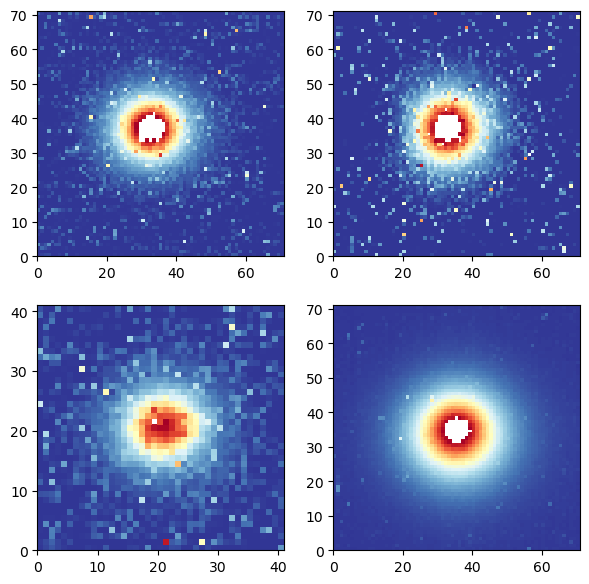

PyObject <matplotlib.collections.QuadMesh object at 0x7f05591540a0>

In [11]:
fig, ax = plt.subplots(2,2, figsize=(7,7))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

ax[1,1].pcolormesh(event.cam_1, cmap="RdYlBu_r")
ax[1,2].pcolormesh(event.cam_2, cmap="RdYlBu_r")
ax[2,1].pcolormesh(event.cam_3, cmap="RdYlBu_r")
ax[2,2].pcolormesh(event.cam_4, cmap="RdYlBu_r")

In [12]:
# Images with no truncated pixels:
  
images = load("../../data/experiment/dataset_2/m2/images.jld2")

global event = (
        cam_1 = images["cam_1"][event_number,:,:],
        cam_2 = images["cam_2"][event_number,:,:],
        cam_3 = images["cam_3"][event_number,:,:],
        cam_4 = images["cam_4"][event_number,:,:],
        population = images["charge"][event_number,:][1],
    );


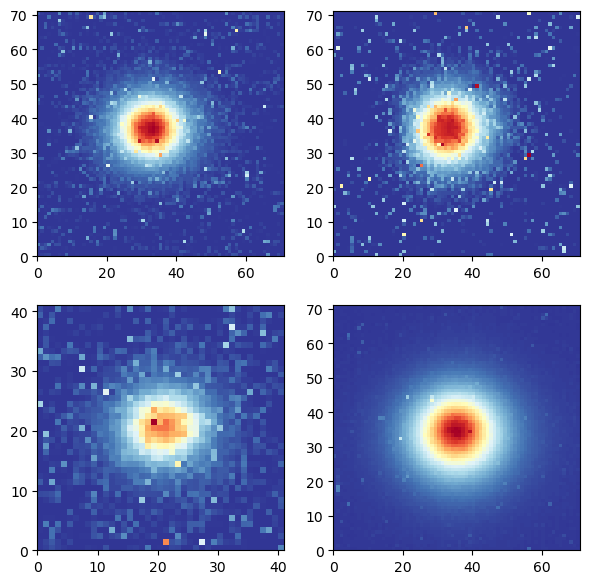

PyObject <matplotlib.collections.QuadMesh object at 0x7f055900daf0>

In [13]:
fig, ax = plt.subplots(2,2, figsize=(7,7))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

ax[1,1].pcolormesh(event.cam_1, cmap="RdYlBu_r")
ax[1,2].pcolormesh(event.cam_2, cmap="RdYlBu_r")
ax[2,1].pcolormesh(event.cam_3, cmap="RdYlBu_r")
ax[2,2].pcolormesh(event.cam_4, cmap="RdYlBu_r")

# Load Model

In [15]:
include("../model-41/likelihood.jl")
include("../model-41/utill_model.jl")
include("../utill.jl")

plot_projections_prl (generic function with 1 method)

In [16]:
β1= 0.015
β2 = 0.0077
β3 = 0.0058 

prior = NamedTupleDist(
        tr_size = [truncated(Normal(0.2, 0.04), 0.03, 0.19), truncated(Normal(0.2, 0.04), 0.03, 0.19)],
        tr_size_2 = [truncated(Normal(0.2, 0.04), 0.03, 0.19), truncated(Normal(0.2, 0.04), 0.03, 0.19)],
        ang_spr = [truncated(Normal(4.0, 2.0), 1.0, 8.0), truncated(Normal(4.0, 2.0), 1.0, 8.0)],
        ang_spr_2 = [truncated(Normal(4.0, 2.0), 1.0, 4.0), truncated(Normal(4.0, 2.0), 1.0, 4.0)],
        mixt_pow =  0.35 .. 1.0, 
        waist = [truncated(Normal(2.774, 0.03), 2.5, 3.6)],
        waist_2 = [truncated(Normal(2.774, 0.03), 2.5, 3.6)],
        algmx = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
        algmy = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
        cam4_ped = 4.0 .. 40.0,
        cam4_light_fluct = 1.0 .. 3.0,
        cam4_light_amp = 1.6 .. 9.9, 
        resx = [1, 1, 1], # 23, 24, 25, 
        resy = [1, 1, 1], # 26,27, 28, 
        cam4_resx = truncated(Normal(3, 1.5), 0, Inf),
        cam4_resy = truncated(Normal(3, 1.5), 0, Inf), 
        psx = [27.1, 21.6, 114.0], # 31, 32, 33
        psy = [30.5, 23.4, 125.0], # 34, 35, 36
        cam4_psx = 121.8, # 37
        cam4_psy = 120.0, # 38
        light_amp  = [1.0 .. 13.0 , 1.0 .. 17.0, 1.0 .. 5.0], # 1.0 .. 5.0
        s_cam = [0.0, 1.47799, 15.025999, 23.1644],
);


# MCMC settings: 

In [17]:
"""
    Log-Likelihood of the beamline (4 cameras included)
"""
function log_lik_ndiff(;  
    e = event,
    cv_mat = conv_matrices,
    func = conv_tabl_discrete,
    cv_1 = cv_mat.cam_1,
    cv_2 = cv_mat.cam_2,
    cv_3 = cv_mat.cam_3,
    n_threads = Threads.nthreads(),
    )
    
    return params -> begin 
        ll = 0.0
        ll += likelihood_cam13(params, e.cam_1, e.population, cv_1, func, 1, n_threads=n_threads)
        ll += likelihood_cam13(params, e.cam_2, e.population, cv_2, func, 2, n_threads=n_threads)
        ll += likelihood_cam13(params, e.cam_3, e.population, cv_3, func, 3, n_threads=n_threads)
        ll += likelihood_cam4(params, e.cam_4, e.population, 4, n_threads=n_threads)
        return LogDVal(ll)
    end
        
end

function log_lik_diff(;  
    e = event,
    cv_mat = conv_matrices,
    func = conv_tabl_cont,
    cv_1 = exp.(cv_mat.cam_1),
    cv_2 = exp.(cv_mat.cam_2),
    cv_3 = exp.(cv_mat.cam_3),
    n_threads = Threads.nthreads(),
    )
    
    return params -> begin 
        ll = 0.0
        ll += likelihood_cam13(params, e.cam_1, e.population, cv_1, func, 1, n_threads=n_threads)
        ll += likelihood_cam13(params, e.cam_2, e.population, cv_2, func, 2, n_threads=n_threads)
        ll += likelihood_cam13(params, e.cam_3, e.population, cv_3, func, 3, n_threads=n_threads)
        ll += likelihood_cam4(params, e.cam_4, e.population, 4, n_threads=n_threads)
        return LogDVal(ll)
    end
    
end

# log_likelihood = log_lik_diff()

log_likelihood = log_lik_ndiff()

#81 (generic function with 1 method)

In [18]:
posterior = PosteriorDensity(log_likelihood, prior)

tuning = AdaptiveMHTuning(
    λ = 0.5,
    α = ClosedInterval(0.15,0.25),
    β = 1.5,
    c = ClosedInterval(1e-4,1e2),
    r = 0.5,
)

mcmcalgo = MetropolisHastings(
    weighting = RepetitionWeighting(),
    tuning = tuning
)

rng = Philox4x()

init = MCMCChainPoolInit(
    init_tries_per_chain = 50 .. 150,
    nsteps_init = 1500
)

burnin = MCMCMultiCycleBurnin(
    max_ncycles = 160,
    nsteps_per_cycle = 40000
)

nsamples = 5*10^5
nchains = 4

convergence = BrooksGelmanConvergence(threshold=1.15);

In [ ]:
@time samples_tot = bat_sample(
    rng, posterior,
    MCMCSampling(
        mcalg = mcmcalgo,
        trafo = NoDensityTransform(),
        nchains = nchains,
        nsteps = nsamples,
        init = init,
        burnin = burnin,
        convergence = convergence,
        strict = false,
#         store_burnin = false,
#         nonzero_weights = true,
    )
);

┌ Info: Using tranform algorithm DensityIdentityTransform()
└ @ BAT /user/.julia/packages/BAT/8MnfJ/src/algotypes/bat_default.jl:44
┌ Info: Trying to generate 4 viable MCMC chain(s).
└ @ BAT /user/.julia/packages/BAT/8MnfJ/src/samplers/mcmc/chain_pool_init.jl:56
┌ Info: Selected 4 MCMC chain(s).
└ @ BAT /user/.julia/packages/BAT/8MnfJ/src/samplers/mcmc/chain_pool_init.jl:173
┌ Info: Begin tuning of 4 MCMC chain(s).
└ @ BAT /user/.julia/packages/BAT/8MnfJ/src/samplers/mcmc/multi_cycle_burnin.jl:35
┌ Info: MCMC Tuning cycle 1 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /user/.julia/packages/BAT/8MnfJ/src/samplers/mcmc/multi_cycle_burnin.jl:65
┌ Info: MCMC Tuning cycle 2 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /user/.julia/packages/BAT/8MnfJ/src/samplers/mcmc/multi_cycle_burnin.jl:65
┌ Info: MCMC Tuning cycle 3 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /user/.julia/packages/BAT/8MnfJ/src/samplers/mcmc/multi_cycle_burnin.jl:65
┌ Info: MCMC Tuning cycle 4 finished, 4

In [22]:
samples = samples_tot.result;

In [24]:
minimum(bat_eff_sample_size(unshaped.(samples)).result)

1947.5115783239485

In [27]:
size(flatview(unshaped.(samples.v)))

(27, 445888)

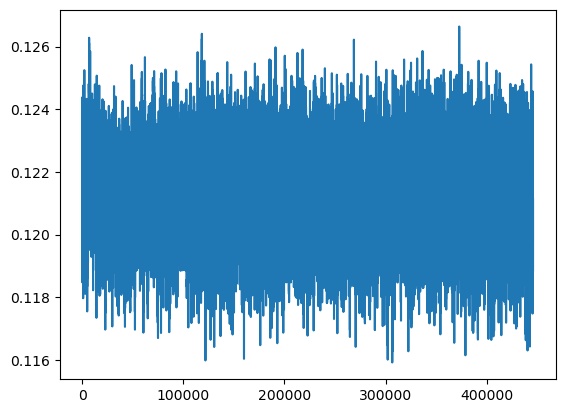

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f04e68055b0>

In [28]:
plot(flatview(unshaped.(samples.v))[3,:])

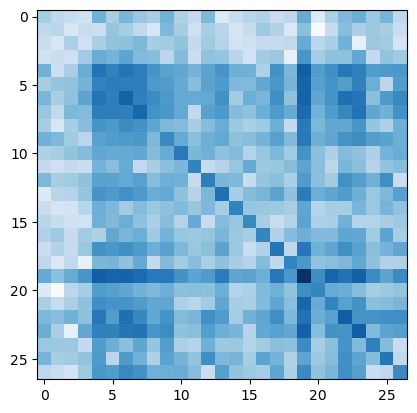

PyObject <matplotlib.image.AxesImage object at 0x7f05d30a1670>

In [29]:
plt.imshow(log.(abs.(cov(flatview(unshaped.(samples.v))'))), cmap="Blues")

In [43]:
# BAT.bat_write("../../data/sampling_results/Benchmark-16/samples-hc-90-nontruncated.hdf5", unshaped.(samples))

# BAT.bat_write("../data/sampling_results/Benchmark-14/samples-res-upd.hdf5", unshaped.(samples))

In [30]:
mode(samples)[1]

(tr_size = [0.09230590792780291, 0.14214846241633464], tr_size_2 = [0.1212034669680515, 0.11754465019015674], ang_spr = [5.896070153292376, 5.411377553595004], ang_spr_2 = [2.1997000850002495, 2.100235002508883], mixt_pow = 0.7606912296980155, waist = [3.1232237877156805], waist_2 = [2.70759674991223], algmx = [32.86286423267236, 33.38260645306253, 21.142078111460584, 35.739832186177836], algmy = [37.13147918287955, 37.13935636495153, 20.708797310121703, 34.12572520967651], cam4_ped = 30.202587215159507, cam4_light_fluct = 1.9518107094434334, cam4_light_amp = 8.437833888074099, resx = [1, 1, 1], resy = [1, 1, 1], cam4_resx = 4.340997541953015, cam4_resy = 4.1893246419539, psx = [27.1, 21.6, 114.0], psy = [30.5, 23.4, 125.0], cam4_psx = 121.8, cam4_psy = 120.0, light_amp = [8.42024021977304, 10.758283744626803, 2.6653324340263738], s_cam = [0.0, 1.47799, 15.025999, 23.1644])

In [31]:
bat_marginalmode(samples).result

ShapedAsNT((tr_size = [0.09295, 0.142575], tr_size_2 = [0.121575, 0.11754999999999999], ang_spr = [5.871, 5.404999999999999], ang_spr_2 = [2.1475, 2.0925000000000002], mixt_pow = 0.76275, waist = [3.1135], waist_2 = [2.713], algmx = [32.8465, 33.3805, 21.119, 35.7435], algmy = [37.1165, 37.1325, 20.721, 34.1055], cam4_ped = 30.21, cam4_light_fluct = 1.9595, cam4_light_amp = 8.4535, resx = [1, 1, 1], resy = [1, 1, 1], cam4_resx = 4.4125, cam4_resy = 4.202500000000001, psx = [27.1, 21.6, 114.0], psy = [30.5, 23.4, 125.0], cam4_psx = 121.8, cam4_psy = 120.0, light_amp = [8.4055, 10.771, 2.6555], s_cam = [0.0, 1.47799, 15.025999, 23.1644]))

In [32]:
mean(samples)[1]

(tr_size = [0.09331947250690517, 0.14278825611052917], tr_size_2 = [0.12122950083555507, 0.11725605852947517], ang_spr = [5.8607216109770945, 5.396837050930826], ang_spr_2 = [2.1461837553987904, 2.089881038810951], mixt_pow = 0.763331240303114, waist = [3.116847474803126], waist_2 = [2.709576952053146], algmx = [32.84738937860087, 33.383882367557966, 21.11820694648319, 35.74339244753153], algmy = [37.11537963941339, 37.13240685876406, 20.724073213080818, 34.10616363452656], cam4_ped = 30.238928232888927, cam4_light_fluct = 1.9587523824926423, cam4_light_amp = 8.450007585845071, resx = [1, 1, 1], resy = [1, 1, 1], cam4_resx = 4.418851362425973, cam4_resy = 4.185069415359137, psx = [27.1, 21.6, 114.0], psy = [30.5, 23.4, 125.0], cam4_psx = 121.8, cam4_psy = 120.0, light_amp = [8.405209450631235, 10.774644054392487, 2.657279042321445], s_cam = [0.0, 1.47799, 15.025999, 23.1644])

In [33]:
std(samples)[1]

(tr_size = [0.0015822859018323823, 0.0008823282598032131], tr_size_2 = [0.001248648757148537, 0.0017449654765745444], ang_spr = [0.035412383481855825, 0.02654410030731638], ang_spr_2 = [0.060920219706020524, 0.053313845545103516], mixt_pow = 0.006937051330178191, waist = [0.017933917292688045], waist_2 = [0.029412334878039115], algmx = [0.021506171273860536, 0.025051562374598966, 0.0390545754690015, 0.02212499395189375], algmy = [0.01820940401108646, 0.019816261796074673, 0.03195951987917952, 0.020632412821907715], cam4_ped = 0.2881711864606529, cam4_light_fluct = 0.020050255052243292, cam4_light_amp = 0.02152536280717067, resx = 3-element Fill{Int64}: entries equal to 0, resy = 3-element Fill{Int64}: entries equal to 0, cam4_resx = 0.06892565580286789, cam4_resy = 0.06873847902355651, psx = 3-element Fill{Float64}: entries equal to 0.0, psy = 3-element Fill{Float64}: entries equal to 0.0, cam4_psx = 0.0, cam4_psy = 0.0, light_amp = [0.023454916523575262, 0.03179811231685244, 0.0179590

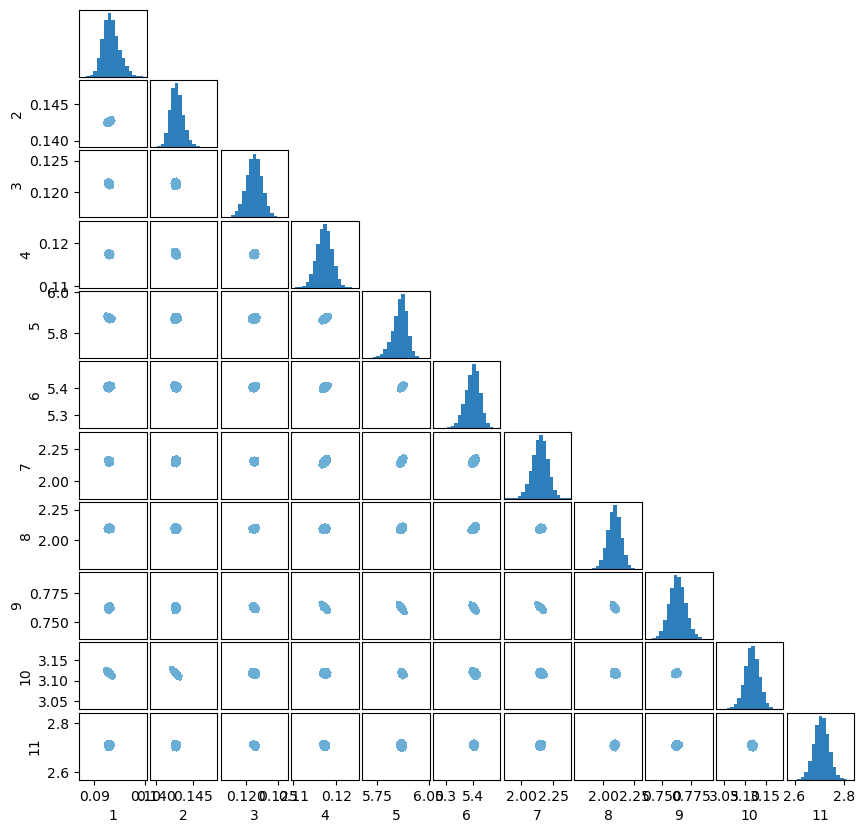

In [34]:
dims = [1,2,3,4,5,6,7,8,9,10,11]
# dims = [1,2,3,4,5,]
names = [1,2,3,4,5,6,7,8,9,10, 11]
levels = [0.01, 0.55, 0.9, 0.95,  1,]
levels = [0.001, 0.98, 1,]
figsize = (10,10)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

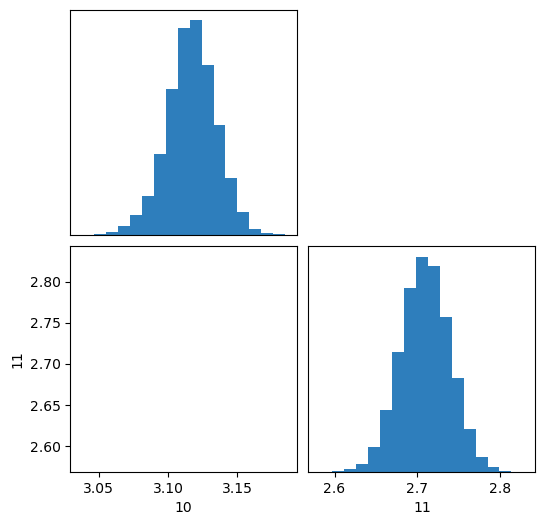

In [35]:
dims = [10,11,]
names = [10,11,]
levels = [0.1, 0.8, 0.9, 0.95,  1,]
levels = [0.1,  1,]
figsize = (6,6)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

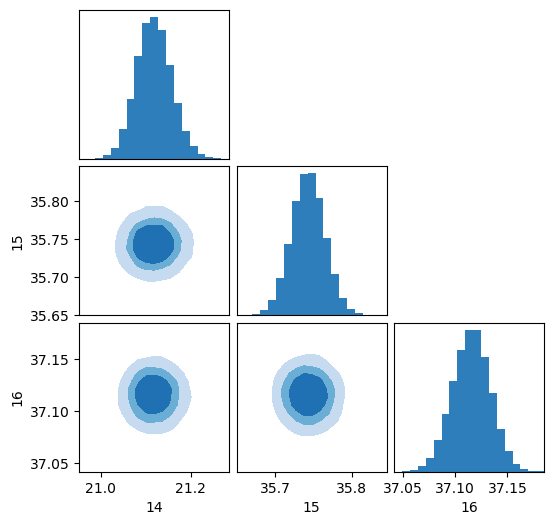

In [36]:
dims = [14,15,16,]
names = [14,15,16,]
levels = [0.1, 0.8, 0.9, 0.95,  1,]
# levels = [0.1, 0.5, 1,]
figsize = (6,6)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

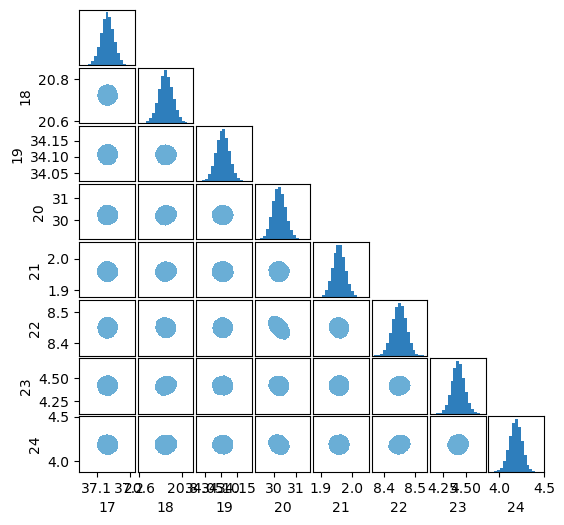

In [37]:
# res

dims = [17,18,19,20,21,22,23,24]
names = [17,18,19,20,21, 22, 23, 24]
levels = [0.1, 0.5, 0.9, 0.95,  1,]
levels = [0.1, 0.9, 1,]
figsize = (6,6)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

In [38]:
#pix

dims = [25,26,27,28,29, 30, 31, 32]
names = [25,26,27,28,29, 30, 31, 32]
levels = [0.1, 0.8, 0.9, 0.95, 1,]
levels = [0.1, 0.5, 1,]
figsize = (8,8)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

LoadError: BoundsError: attempt to access 27×445888 ElasticArrays.ElasticMatrix{Float64, 1, Vector{Float64}} at index [28, 1:445888]

In [39]:
dims = [33, 34, 35]
names = [33, 34, 35]
levels = [0.1, 0.8, 0.9, 0.95, 1,]
# levels = [0.1, 0.5, 1,]
figsize = (6,6)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

LoadError: BoundsError: attempt to access 27×445888 ElasticArrays.ElasticMatrix{Float64, 1, Vector{Float64}} at index [33, 1:445888]

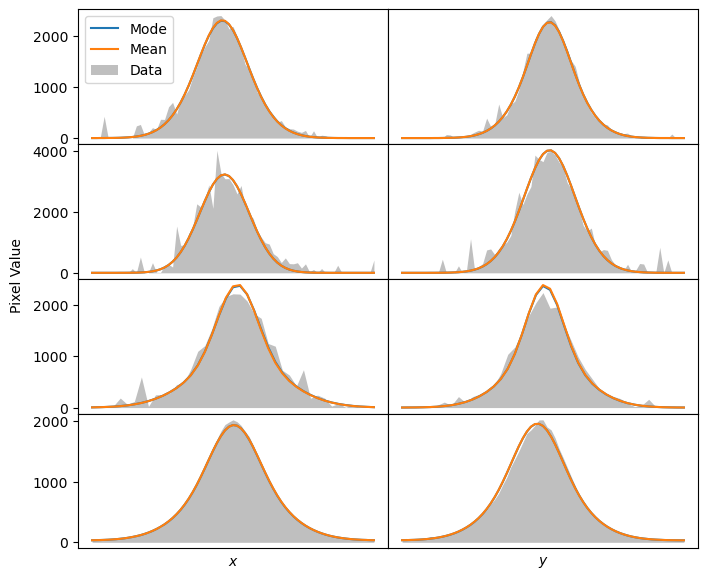

PyObject Text(0.04, 0.5, 'Pixel Value')

In [40]:
colors_array = ["C0", "C1"]
labels_array = ["Mode", "Mean"]
params_array = [mode(samples)[1], mean(samples)[1]]

plot_cam_crossections(params_array, event, conv_matrices, colors = colors_array, labels=labels_array)

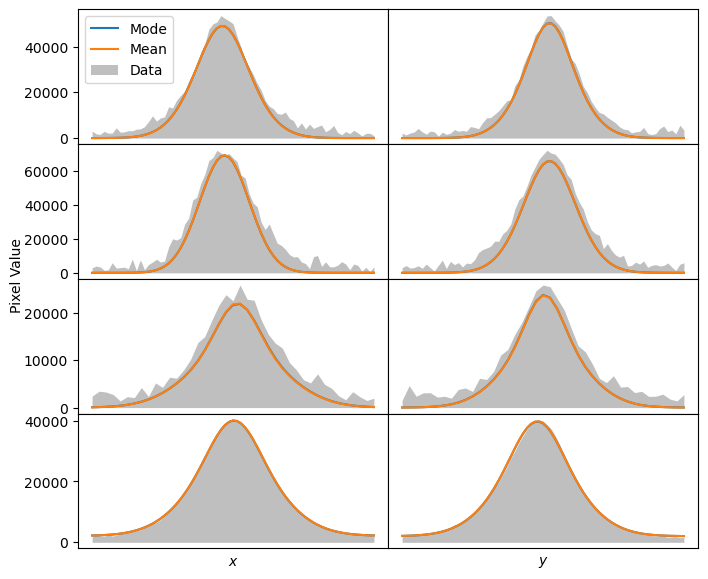

PyObject Text(0.04, 0.5, 'Pixel Value')

In [41]:
colors_array = ["C0", "C1"]
labels_array = ["Mode", "Mean"]
params_array = [mode(samples)[1], mean(samples)[1]]

plot_cam_integral(params_array, event, conv_matrices, colors = colors_array, labels=labels_array)

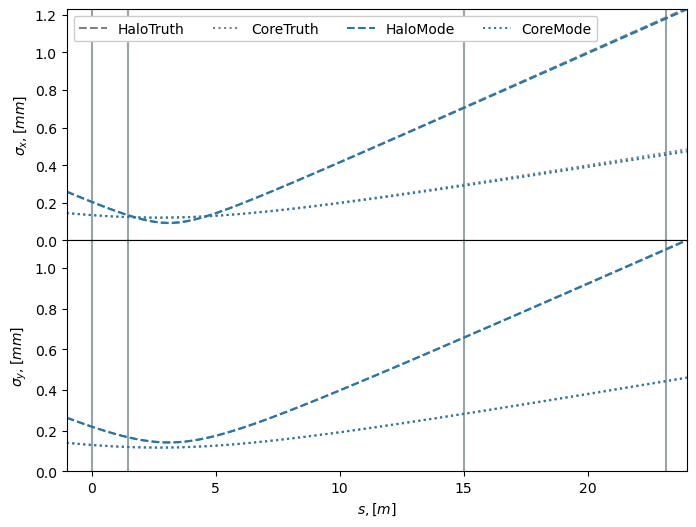

PyObject Text(0.5, 26.28125, '$s, [m]$')

In [42]:
params_array = [mode(samples)[1], mean(samples)[1]]
colors_array = ["gray", "C0", "C1"]
labels_array = ["Truth", "Mode", "Mean"]

plot_envelop_trajectory(params_array,  labels = labels_array, colors=colors_array)

In [ ]:
images = load("../data/experiment/dataset_2/m2/images.jld2")
event_ns = (
    cam_1 = images["cam_1"][event_number,:,:],
    cam_2 = images["cam_2"][event_number,:,:],
    cam_3 = images["cam_3"][event_number,:,:],
    cam_4 = images["cam_4"][event_number,:,:],
    population = images["charge"][event_number,:][1],
);

In [ ]:
plot_projections(conv_matrices, event_ns, event, params_array[1], isnontr = true)

In [ ]:
# try model 38 with light fluctuations constant on the IS2
# fixe resolution in the IS2 amera